# Executive Summary
Name: Andrew Zhao

Trojan airlines is examining their price policy for the LAX to SFO flight every Thursday evening. The sell horizon is 180 days before departure. There are two main segments of customers: leisure and business. There are three main pricing strategies that were explored in this notebook. A constant pricing strategy that stays the same during the whole sell horizon. A dynamic pricing strategy which is charging a price 1 from day 180 to day 14, then changing it to some new price value price 2, where price 2 >= price 1. Finally, the last pricing strategy is the capacity rationing strategy where price 1 will be constant until there are l seats left. After that, price 2 will be charged. Again, price 1 <= price 2. 

After simulating the three strategies, the following results are found:
~~~ 
Constant price policy : best p = 250, estimated expected profit = $2737.50.

Dynamic price policy : best p1 = 240, best p2 = 315, estimated expected profit = $3448.60.

Capacity rationing price policy : best p1 = 235, best p2 = 330, best l = 34, estimated expected profit = $3813.55.
~~~

From the results, we suggest Trojan airlines to deploy the capacity rationing price strategy, with constant price of 235 dollars until there are 34 seats left, then change the price to 330 dollars. The expected percentage gain in expected profit with this strategy compared to the constant price policy is 39.31%

In [423]:
from scipy.stats import uniform
from scipy.stats import binom
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [424]:
#leisure customers
leisure_size = norm(200, 60)
leisure_time = uniform(0, 180)
leisure_pay = norm(200, 80)

In [425]:
#business customers
business_size = norm(60, 20)
business_time = uniform(0, 14)
business_pay = norm(350, 120)

# Generate Customers DataFrame

In [426]:
def generateCustomers():
    lei_size = leisure_size.rvs()
    bus_size = business_size.rvs()
    if lei_size < 0:
        lei_size = 0
    if bus_size < 0:
        bus_size = 0
    lei_time = leisure_time.rvs(size = int(lei_size))
    lei_wp = leisure_pay.rvs(size = int(lei_size))
    lei_stat = ['Leisure'] * int(lei_size)
    bus_time = business_time.rvs(size = int(bus_size))
    bus_wp = business_pay.rvs(size = int(bus_size))
    bus_stat = ['Business'] * int(bus_size)
    df1 = {'arrival_time': lei_time, 'valuation': lei_wp, 'Customer': lei_stat}
    df2 = {'arrival_time': bus_time, 'valuation': bus_wp, 'Customer': bus_stat}
    df1 = pd.DataFrame(df1)
    df2 = pd.DataFrame(df2)
    df = pd.concat([df1, df2])
    df = df.sort_values('arrival_time',ascending = False)
    df.reset_index(inplace = True)
    df = df.drop('index', axis = 1)
    return df
generateCustomers()

,arrival_time,valuation,Customer
0,179.828075,244.118652,Leisure
1,178.027181,122.538949,Leisure
2,176.977640,250.343709,Leisure
3,175.279336,159.814127,Leisure
4,175.262610,273.015949,Leisure
...,...,...,...
232,1.528394,250.546443,Leisure
233,1.463071,315.626724,Business
234,1.398251,199.905238,Business
235,0.675448,179.005183,Business


# Functions for three policies

In [428]:
def simulateConstant(customers, seats, p):
    customers.sort_values('arrival_time',ascending = False)
    customers = customers[customers['valuation'] >= p].head(seats)
    total_revenue = len(customers) * p
    return total_revenue

In [473]:
def simulateDynamic(customers, seats, p1, p2):
    customers.sort_values('arrival_time',ascending = False)
    customers180 = customers.copy()
    customers180 = customers180[(customers180['valuation'] >= p1) & (customers180['arrival_time'] > 14)].head(seats)
    seatsleft = seats - min(len(customers180), seats)
    customers14 = customers.copy()
    customers14 = customers14[(customers14['valuation'] >= p2) & (customers14['arrival_time'] <= 14)].head(seatsleft)
    total_revenue = len(customers180) * p1 + len(customers14) * p2
    return total_revenue

In [430]:
def simulateRationing(customers, seats, p1, p2, l):
    customers.sort_values('arrival_time',ascending = False)
    customers_before = customers.copy()
    customers_before = customers_before[(customers_before['valuation'] >= p1)]
    customers_after = customers_before.iloc[seats - l:]
    customers_before = customers_before.head(seats - l)
    customers_after = customers_after[(customers_after['valuation'] >= p2)].head(l)
    total_revenue = len(customers_before) * p1 + len(customers_after) * p2
    return total_revenue

# Simulation

In [439]:
#fixed variables creation
FIXED_COST = 20000
FLIGHTSEATS = 100
fixed_prices = [price for price in range(200, 350, 5)]
seats_left = [seat for seat in range(20, 55, 1)]
customer_scenarios = [generateCustomers() for _ in range(100)]

### Constant pricing strategy

In [451]:
maxrevenueC = -float('inf')
optpriceC = None
for price in fixed_prices:
    revenue_price = []
    for scenario in customer_scenarios:
        revenue = simulateConstant(scenario, seats = FLIGHTSEATS, p = price)
        revenue_price.append(revenue)
    revenue_mean = pd.Series(revenue_price).mean() - FIXED_COST
    if revenue_mean > maxrevenueC:
        maxrevenueC = revenue_mean
        optpriceC = price
print(f'Constant price policy : best p = {optpriceC}, estimated expected profit = ${maxrevenueC:.2f}.')

Constant price policy : best p = 250, estimated expected profit = $2737.50.


### Dynamic Pricing Strategy

In [474]:
maxrevenueD = -float('inf')
optpriceD = None
optprice2D = None
for price in fixed_prices:
    for price2 in range(price, 350, 5):
        revenue_price = []
        for scenario in customer_scenarios:
            revenue = simulateDynamic(scenario, seats = FLIGHTSEATS, p1 = price, p2 = price2)
            revenue_price.append(revenue)
        revenue_mean = pd.Series(revenue_price).mean() - FIXED_COST
        if revenue_mean > maxrevenueD:
            maxrevenueD = revenue_mean
            optpriceD = price
            optprice2D = price2
print(f'Dynamic price policy : best p1 = {optpriceD}, best p2 = {optprice2D}, estimated expected profit = ${maxrevenueD:.2f}.')

Dynamic price policy : best p1 = 240, best p2 = 315, estimated expected profit = $3448.60.


In [452]:
Expected_Gain_D = maxrevenueD / (maxrevenueC) - 1
print(f'The expected increase profit from the constant pricing strategy is {Expected_Gain_D * 100:.2f}%')

The expected increase profit from the constant pricing strategy is 25.98%


### Capacity Rationing Pricing Strategy

In [442]:
maxrevenueR = -float('inf')
optpriceR = None
optprice2R = None
optseats = None
for price in fixed_prices:
    for seat in seats_left:
        for price2 in range(price, 350, 5):
            revenue_price = []
            for scenario in customer_scenarios:
                revenue = simulateRationing(scenario, seats = FLIGHTSEATS, p1 = price, p2 = price2, l = seat)
                revenue_price.append(revenue)
            revenue_mean = pd.Series(revenue_price).mean() - FIXED_COST
            if revenue_mean > maxrevenueR:
                maxrevenueR = revenue_mean
                optpriceR = price
                optprice2R = price2
                optseats = seat
print(f'Capacity rationing price policy : best p1 = {optpriceR}, best p2 = {optprice2R}, best l = {optseats}, \nestimated expected profit = ${maxrevenueR:.2f}.')

Capacity rationing price policy : best p1 = 235, best p2 = 330, best l = 34, 
estimated expected profit = $3813.55.


In [453]:
Expected_Gain_R = maxrevenueR / (maxrevenueC) - 1
print(f'The expected increase profit from the constant pricing strategy is {Expected_Gain_R * 100:.2f}%')

The expected increase profit from the constant pricing strategy is 39.31%


### Testing

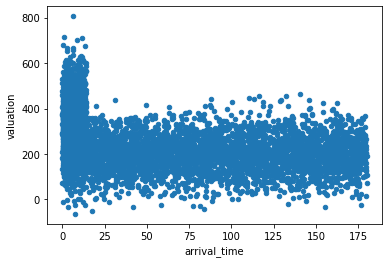

In [455]:
np.random.seed(0)
pd.concat([generateCustomers() for i in range(20)])\
.plot(x = 'arrival_time', y = 'valuation', kind = 'scatter')

In [454]:
import pandas as pd
data=[[170,50],[150,40],[13,95],[12,100]]
customers=pd.DataFrame(data,columns=['arrival_time','valuation'])
print('Constant policy with 2 seats p=50 \t:',simulateConstant(customers,2,50))
print('Constant policy with 2 seats p=100 \t:',simulateConstant(customers,2,100))
print('Dynamic policy with 3 seats p1=40, p2=95 \t:',simulateDynamic(customers,3,40,95))
print('Dynamic policy with 2 seats p1=40, p2=95 \t:',simulateDynamic(customers,2,40,95))
print('Dynamic policy with 1 seats p1=50, p2=100 \t:',simulateDynamic(customers,1,50,100))
print('Rationing policy with 3 seats p1=40, p2=100, l=1 \t:',\
simulateRationing(customers,3,40,100,1))
print('Rationing policy with 2 seats p1=40, p2=100, l=1 \t:',\
simulateRationing(customers,2,40,100,1))
print('Rationing policy with 1 seats p1=40, p2=95, l=1 \t:',\
simulateRationing(customers,1,40,95,1))

Constant policy with 2 seats p=50 	: 100
Constant policy with 2 seats p=100 	: 100
Dynamic policy with 3 seats p1=40, p2=95 	: 175
Dynamic policy with 2 seats p1=40, p2=95 	: 80
Dynamic policy with 1 seats p1=50, p2=100 	: 50
Rationing policy with 3 seats p1=40, p2=100, l=1 	: 180
Rationing policy with 2 seats p1=40, p2=100, l=1 	: 140
Rationing policy with 1 seats p1=40, p2=95, l=1 	: 95
